In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

np.random.seed(seed=7)

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

This conv2d network is more inspired from a classic conv2d net that is used for image recognition 

In [3]:
from models import *

# Preprocessing and Data Augmentation

In [4]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target, kept_channels_idx = preprocessing_train(train_input_1000, train_target_1000, subsampling_frequency='100Hz', window=False,denoize=False, addGaussianNoise=False, reduceChannels=False, cutEnd = False)
preprocessed_input_test, preprocessed_input_test_target  = preprocessing_test(test_input_1000, test_target_1000, kept_channels_idx, subsampling_frequency='100Hz', window=False,denoize = False, reduceChannels=False, cutEnd=False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = torch.from_numpy(preprocessed_input_test_target)
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

Nchannels = len(preprocessed_input_train[0,:,0])
Nsamples_100 = preprocessed_input_train.size(-1)

print('Ntrain = ', Ntrain)
print('Ntest = ', Ntest)
print('Nvalidation = ', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), requires_grad=False)
test_input = Variable(preprocessed_input_test.contiguous().view(Ntest, 1, Nchannels, Nsamples_100), requires_grad=False)

train (3000, 28, 50)
test (1000, 28, 50)
validation (160, 28, 50)
Ntrain =  3000
Ntest =  1000
Nvalidation =  160


# Network training and testing

In [5]:
import torch.optim as optim
import math

# Train network 
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False)
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False )
    Noutputs = 2
    
else:
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float(), requires_grad=False) # convert to float
    test_target = Variable(labels_test.float(), requires_grad=False)
    Noutputs = 1

batch_size = 7
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 50
seeds = list(range(50))
#seeds = [14,20,21,22,27,46,44,37,31,28]
Nrep = len(seeds)

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):
    
    print('Repetition', seeds[i_rep])
    torch.manual_seed(seeds[i_rep])
    #model = conv2DNet_1(Noutputs) #from classic knowledge of image segmentation  
    #model = conv2DNet_2(Nchannels, Nsamples_100, Noutputs) #from litterature 
    #model = conv2DNet_3(Noutputs) #from PdM
    #model = conv2DNet_4(Noutputs) #from PdM
    #model = conv2DNet_5(Noutputs)
    #model = conv2DNet_6(Noutputs)
    #model = conv2DNet_7(Noutputs)
    model = conv2DNet_9(Noutputs)
    
    #optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    #optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model.forward(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output.view(bsize_eff), train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size, criterion)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size, criterion)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size, criterion)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        test_errors[i_rep, i_ep] = nb_test_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Repetition 0
Epoch Number :  0
	 Training accuracy:  62.7
	 Validation accuracy  60.0
	 Test accuracy  61.7
	 Epoch Loss  291.7895812988281
Epoch Number :  1
	 Training accuracy:  82.26666666666667
	 Validation accuracy  85.0
	 Test accuracy  76.0
	 Epoch Loss  244.9044952392578
Epoch Number :  2
	 Training accuracy:  86.6
	 Validation accuracy  85.0
	 Test accuracy  79.7
	 Epoch Loss  202.36935424804688
Epoch Number :  3
	 Training accuracy:  87.56666666666666
	 Validation accuracy  87.5
	 Test accuracy  80.6
	 Epoch Loss  184.0196533203125
Epoch Number :  4
	 Training accuracy:  88.56666666666666
	 Validation accuracy  85.625
	 Test accuracy  80.7
	 Epoch Loss  176.47268676757812
Epoch Number :  5
	 Training accuracy:  87.73333333333333
	 Validation accuracy  79.375
	 Test accuracy  78.5
	 Epoch Loss  167.88084411621094
Epoch Number :  6
	 Training accuracy:  88.4
	 Validation accuracy  71.875
	 Test accuracy  79.1
	 Epoch Loss  154.9813690185547
Epoch Number :  7
	 Training accuracy

Epoch Number :  10
	 Training accuracy:  95.7
	 Validation accuracy  80.0
	 Test accuracy  77.4
	 Epoch Loss  120.13732147216797
Epoch Number :  11
	 Training accuracy:  93.76666666666667
	 Validation accuracy  81.875
	 Test accuracy  76.1
	 Epoch Loss  117.00143432617188
Epoch Number :  12
	 Training accuracy:  96.7
	 Validation accuracy  81.875
	 Test accuracy  78.3
	 Epoch Loss  110.62950897216797
Epoch Number :  13
	 Training accuracy:  94.93333333333334
	 Validation accuracy  83.75
	 Test accuracy  76.6
	 Epoch Loss  105.20565795898438
Epoch Number :  14
	 Training accuracy:  97.63333333333334
	 Validation accuracy  79.375
	 Test accuracy  77.5
	 Epoch Loss  119.70430755615234
Epoch Number :  15
	 Training accuracy:  95.53333333333333
	 Validation accuracy  81.25
	 Test accuracy  81.6
	 Epoch Loss  102.27383422851562
Epoch Number :  16
	 Training accuracy:  98.23333333333333
	 Validation accuracy  76.875
	 Test accuracy  73.1
	 Epoch Loss  111.0218505859375
Epoch Number :  17
	 Tr

Epoch Number :  20
	 Training accuracy:  96.13333333333334
	 Validation accuracy  72.5
	 Test accuracy  74.3
	 Epoch Loss  102.42168426513672
Epoch Number :  21
	 Training accuracy:  94.6
	 Validation accuracy  75.625
	 Test accuracy  81.3
	 Epoch Loss  102.70500946044922
Epoch Number :  22
	 Training accuracy:  92.36666666666666
	 Validation accuracy  81.875
	 Test accuracy  78.8
	 Epoch Loss  97.28260040283203
Epoch Number :  23
	 Training accuracy:  94.53333333333333
	 Validation accuracy  75.625
	 Test accuracy  82.2
	 Epoch Loss  99.37171173095703
Epoch Number :  24
	 Training accuracy:  94.96666666666667
	 Validation accuracy  73.125
	 Test accuracy  76.6
	 Epoch Loss  92.35511779785156
Epoch Number :  25
	 Training accuracy:  98.13333333333334
	 Validation accuracy  73.75
	 Test accuracy  78.4
	 Epoch Loss  97.23596954345703
Epoch Number :  26
	 Training accuracy:  92.63333333333334
	 Validation accuracy  70.625
	 Test accuracy  78.8
	 Epoch Loss  92.2685775756836
Epoch Number :

Epoch Number :  30
	 Training accuracy:  89.46666666666667
	 Validation accuracy  79.375
	 Test accuracy  77.8
	 Epoch Loss  94.927734375
Epoch Number :  31
	 Training accuracy:  97.53333333333333
	 Validation accuracy  69.375
	 Test accuracy  80.4
	 Epoch Loss  87.43312072753906
Epoch Number :  32
	 Training accuracy:  96.6
	 Validation accuracy  79.375
	 Test accuracy  81.7
	 Epoch Loss  96.90377807617188
Epoch Number :  33
	 Training accuracy:  95.7
	 Validation accuracy  77.5
	 Test accuracy  81.6
	 Epoch Loss  93.6546630859375
Epoch Number :  34
	 Training accuracy:  96.46666666666667
	 Validation accuracy  82.5
	 Test accuracy  82.0
	 Epoch Loss  90.03047943115234
Epoch Number :  35
	 Training accuracy:  97.9
	 Validation accuracy  78.75
	 Test accuracy  83.1
	 Epoch Loss  93.15846252441406
Epoch Number :  36
	 Training accuracy:  96.36666666666666
	 Validation accuracy  79.375
	 Test accuracy  80.5
	 Epoch Loss  90.41989135742188
Epoch Number :  37
	 Training accuracy:  97.7
	 V

Epoch Number :  40
	 Training accuracy:  98.46666666666667
	 Validation accuracy  90.0
	 Test accuracy  77.2
	 Epoch Loss  80.76439666748047
Epoch Number :  41
	 Training accuracy:  98.8
	 Validation accuracy  89.375
	 Test accuracy  76.8
	 Epoch Loss  83.54376983642578
Epoch Number :  42
	 Training accuracy:  98.86666666666666
	 Validation accuracy  89.375
	 Test accuracy  77.0
	 Epoch Loss  84.97298431396484
Epoch Number :  43
	 Training accuracy:  98.93333333333334
	 Validation accuracy  89.375
	 Test accuracy  76.3
	 Epoch Loss  82.69671630859375
Epoch Number :  44
	 Training accuracy:  98.56666666666666
	 Validation accuracy  90.625
	 Test accuracy  77.5
	 Epoch Loss  80.99261474609375
Epoch Number :  45
	 Training accuracy:  98.76666666666667
	 Validation accuracy  89.375
	 Test accuracy  77.2
	 Epoch Loss  83.107421875
Epoch Number :  46
	 Training accuracy:  98.9
	 Validation accuracy  89.375
	 Test accuracy  76.4
	 Epoch Loss  83.0391616821289
Epoch Number :  47
	 Training acc

Epoch Number :  0
	 Training accuracy:  62.666666666666664
	 Validation accuracy  31.25
	 Test accuracy  47.8
	 Epoch Loss  295.2728271484375
Epoch Number :  1
	 Training accuracy:  69.4
	 Validation accuracy  31.25
	 Test accuracy  48.1
	 Epoch Loss  282.0406494140625
Epoch Number :  2
	 Training accuracy:  75.26666666666667
	 Validation accuracy  43.75
	 Test accuracy  56.8
	 Epoch Loss  255.91781616210938
Epoch Number :  3
	 Training accuracy:  85.23333333333333
	 Validation accuracy  59.375
	 Test accuracy  71.7
	 Epoch Loss  219.04071044921875
Epoch Number :  4
	 Training accuracy:  80.96666666666667
	 Validation accuracy  75.625
	 Test accuracy  71.4
	 Epoch Loss  187.3905487060547
Epoch Number :  5
	 Training accuracy:  90.6
	 Validation accuracy  75.0
	 Test accuracy  73.7
	 Epoch Loss  178.0266571044922
Epoch Number :  6
	 Training accuracy:  94.56666666666666
	 Validation accuracy  77.5
	 Test accuracy  74.7
	 Epoch Loss  163.58236694335938
Epoch Number :  7
	 Training accura

Epoch Number :  10
	 Training accuracy:  97.03333333333333
	 Validation accuracy  83.75
	 Test accuracy  75.7
	 Epoch Loss  115.1680908203125
Epoch Number :  11
	 Training accuracy:  91.96666666666667
	 Validation accuracy  77.5
	 Test accuracy  74.1
	 Epoch Loss  113.39643859863281
Epoch Number :  12
	 Training accuracy:  96.96666666666667
	 Validation accuracy  80.625
	 Test accuracy  77.1
	 Epoch Loss  110.67143249511719
Epoch Number :  13
	 Training accuracy:  97.53333333333333
	 Validation accuracy  83.125
	 Test accuracy  76.6
	 Epoch Loss  107.97453308105469
Epoch Number :  14
	 Training accuracy:  96.46666666666667
	 Validation accuracy  82.5
	 Test accuracy  77.5
	 Epoch Loss  120.05061340332031
Epoch Number :  15
	 Training accuracy:  97.43333333333334
	 Validation accuracy  81.875
	 Test accuracy  78.1
	 Epoch Loss  102.9997329711914
Epoch Number :  16
	 Training accuracy:  96.93333333333334
	 Validation accuracy  80.625
	 Test accuracy  77.4
	 Epoch Loss  107.13797760009766

Epoch Number :  20
	 Training accuracy:  96.53333333333333
	 Validation accuracy  87.5
	 Test accuracy  79.7
	 Epoch Loss  109.37239074707031
Epoch Number :  21
	 Training accuracy:  93.66666666666667
	 Validation accuracy  82.5
	 Test accuracy  75.9
	 Epoch Loss  104.56465148925781
Epoch Number :  22
	 Training accuracy:  95.63333333333334
	 Validation accuracy  74.375
	 Test accuracy  80.4
	 Epoch Loss  100.49779510498047
Epoch Number :  23
	 Training accuracy:  97.8
	 Validation accuracy  83.125
	 Test accuracy  80.5
	 Epoch Loss  102.99822998046875
Epoch Number :  24
	 Training accuracy:  96.3
	 Validation accuracy  91.25
	 Test accuracy  79.0
	 Epoch Loss  95.577392578125
Epoch Number :  25
	 Training accuracy:  95.06666666666666
	 Validation accuracy  79.375
	 Test accuracy  79.9
	 Epoch Loss  100.81817626953125
Epoch Number :  26
	 Training accuracy:  96.03333333333333
	 Validation accuracy  83.125
	 Test accuracy  81.4
	 Epoch Loss  96.44347381591797
Epoch Number :  27
	 Traini

Epoch Number :  30
	 Training accuracy:  97.16666666666667
	 Validation accuracy  90.0
	 Test accuracy  77.4
	 Epoch Loss  91.22084045410156
Epoch Number :  31
	 Training accuracy:  95.76666666666667
	 Validation accuracy  87.5
	 Test accuracy  74.0
	 Epoch Loss  106.76496124267578
Epoch Number :  32
	 Training accuracy:  96.8
	 Validation accuracy  92.5
	 Test accuracy  79.2
	 Epoch Loss  90.45664978027344
Epoch Number :  33
	 Training accuracy:  97.66666666666667
	 Validation accuracy  93.125
	 Test accuracy  78.1
	 Epoch Loss  88.51261138916016
Epoch Number :  34
	 Training accuracy:  97.46666666666667
	 Validation accuracy  92.5
	 Test accuracy  78.0
	 Epoch Loss  89.7948226928711
Epoch Number :  35
	 Training accuracy:  98.0
	 Validation accuracy  93.125
	 Test accuracy  79.4
	 Epoch Loss  84.63526916503906
Epoch Number :  36
	 Training accuracy:  94.73333333333333
	 Validation accuracy  90.0
	 Test accuracy  79.3
	 Epoch Loss  87.14921569824219
Epoch Number :  37
	 Training accur

Epoch Number :  41
	 Training accuracy:  97.9
	 Validation accuracy  78.75
	 Test accuracy  80.8
	 Epoch Loss  86.7005386352539
Epoch Number :  42
	 Training accuracy:  97.83333333333333
	 Validation accuracy  80.0
	 Test accuracy  81.5
	 Epoch Loss  82.79217529296875
Epoch Number :  43
	 Training accuracy:  97.66666666666667
	 Validation accuracy  75.625
	 Test accuracy  80.6
	 Epoch Loss  79.57283782958984
Epoch Number :  44
	 Training accuracy:  97.73333333333333
	 Validation accuracy  80.0
	 Test accuracy  83.1
	 Epoch Loss  98.79882049560547
Epoch Number :  45
	 Training accuracy:  97.83333333333333
	 Validation accuracy  76.875
	 Test accuracy  82.0
	 Epoch Loss  85.37054443359375
Epoch Number :  46
	 Training accuracy:  97.8
	 Validation accuracy  76.25
	 Test accuracy  79.9
	 Epoch Loss  87.4732666015625
Epoch Number :  47
	 Training accuracy:  94.73333333333333
	 Validation accuracy  76.25
	 Test accuracy  78.4
	 Epoch Loss  94.5918197631836
Epoch Number :  48
	 Training accur

Epoch Number :  1
	 Training accuracy:  79.53333333333333
	 Validation accuracy  51.25
	 Test accuracy  57.2
	 Epoch Loss  268.4059753417969
Epoch Number :  2
	 Training accuracy:  90.86666666666666
	 Validation accuracy  66.25
	 Test accuracy  69.4
	 Epoch Loss  227.4453582763672
Epoch Number :  3
	 Training accuracy:  86.1
	 Validation accuracy  61.25
	 Test accuracy  67.4
	 Epoch Loss  183.01271057128906
Epoch Number :  4
	 Training accuracy:  92.76666666666667
	 Validation accuracy  74.375
	 Test accuracy  75.5
	 Epoch Loss  162.8721923828125
Epoch Number :  5
	 Training accuracy:  93.6
	 Validation accuracy  73.125
	 Test accuracy  77.1
	 Epoch Loss  148.1103515625
Epoch Number :  6
	 Training accuracy:  86.36666666666666
	 Validation accuracy  74.375
	 Test accuracy  71.1
	 Epoch Loss  141.05673217773438
Epoch Number :  7
	 Training accuracy:  94.43333333333334
	 Validation accuracy  69.375
	 Test accuracy  75.2
	 Epoch Loss  135.2943115234375
Epoch Number :  8
	 Training accurac

Epoch Number :  10
	 Training accuracy:  95.13333333333334
	 Validation accuracy  88.125
	 Test accuracy  77.0
	 Epoch Loss  117.99415588378906
Epoch Number :  11
	 Training accuracy:  95.46666666666667
	 Validation accuracy  87.5
	 Test accuracy  77.6
	 Epoch Loss  115.80370330810547
Epoch Number :  12
	 Training accuracy:  95.26666666666667
	 Validation accuracy  86.875
	 Test accuracy  80.6
	 Epoch Loss  111.601318359375
Epoch Number :  13
	 Training accuracy:  94.8
	 Validation accuracy  84.375
	 Test accuracy  76.3
	 Epoch Loss  107.6611099243164
Epoch Number :  14
	 Training accuracy:  92.6
	 Validation accuracy  81.875
	 Test accuracy  73.7
	 Epoch Loss  105.5838623046875
Epoch Number :  15
	 Training accuracy:  96.53333333333333
	 Validation accuracy  86.25
	 Test accuracy  76.7
	 Epoch Loss  105.90859985351562
Epoch Number :  16
	 Training accuracy:  94.7
	 Validation accuracy  91.875
	 Test accuracy  75.6
	 Epoch Loss  102.61299896240234
Epoch Number :  17
	 Training accuracy

Epoch Number :  20
	 Training accuracy:  97.53333333333333
	 Validation accuracy  87.5
	 Test accuracy  78.6
	 Epoch Loss  103.17730712890625
Epoch Number :  21
	 Training accuracy:  96.9
	 Validation accuracy  89.375
	 Test accuracy  75.9
	 Epoch Loss  98.45364379882812
Epoch Number :  22
	 Training accuracy:  97.43333333333334
	 Validation accuracy  86.25
	 Test accuracy  78.3
	 Epoch Loss  98.6456069946289
Epoch Number :  23
	 Training accuracy:  97.43333333333334
	 Validation accuracy  86.875
	 Test accuracy  78.6
	 Epoch Loss  100.25453186035156
Epoch Number :  24
	 Training accuracy:  97.76666666666667
	 Validation accuracy  84.375
	 Test accuracy  78.2
	 Epoch Loss  94.70364379882812
Epoch Number :  25
	 Training accuracy:  98.16666666666667
	 Validation accuracy  86.25
	 Test accuracy  76.1
	 Epoch Loss  102.1868896484375
Epoch Number :  26
	 Training accuracy:  97.53333333333333
	 Validation accuracy  83.125
	 Test accuracy  77.5
	 Epoch Loss  93.79617309570312
Epoch Number : 

Epoch Number :  29
	 Training accuracy:  98.13333333333334
	 Validation accuracy  85.625
	 Test accuracy  81.8
	 Epoch Loss  89.75408935546875
Epoch Number :  30
	 Training accuracy:  98.4
	 Validation accuracy  84.375
	 Test accuracy  79.4
	 Epoch Loss  86.47383880615234
Epoch Number :  31
	 Training accuracy:  96.53333333333333
	 Validation accuracy  79.375
	 Test accuracy  79.0
	 Epoch Loss  96.59941864013672
Epoch Number :  32
	 Training accuracy:  95.83333333333333
	 Validation accuracy  80.625
	 Test accuracy  78.3
	 Epoch Loss  83.22200012207031
Epoch Number :  33
	 Training accuracy:  98.4
	 Validation accuracy  85.0
	 Test accuracy  76.7
	 Epoch Loss  89.79206085205078
Epoch Number :  34
	 Training accuracy:  97.76666666666667
	 Validation accuracy  85.0
	 Test accuracy  79.1
	 Epoch Loss  83.9801025390625
Epoch Number :  35
	 Training accuracy:  98.63333333333334
	 Validation accuracy  85.625
	 Test accuracy  76.7
	 Epoch Loss  95.13353729248047
Epoch Number :  36
	 Training 

Epoch Number :  39
	 Training accuracy:  93.43333333333334
	 Validation accuracy  73.75
	 Test accuracy  80.0
	 Epoch Loss  87.12598419189453
Epoch Number :  40
	 Training accuracy:  97.4
	 Validation accuracy  72.5
	 Test accuracy  83.3
	 Epoch Loss  90.87820434570312
Epoch Number :  41
	 Training accuracy:  97.63333333333334
	 Validation accuracy  70.625
	 Test accuracy  82.0
	 Epoch Loss  85.20993041992188
Epoch Number :  42
	 Training accuracy:  98.0
	 Validation accuracy  71.25
	 Test accuracy  85.1
	 Epoch Loss  91.41748809814453
Epoch Number :  43
	 Training accuracy:  97.76666666666667
	 Validation accuracy  73.75
	 Test accuracy  80.7
	 Epoch Loss  81.17984771728516
Epoch Number :  44
	 Training accuracy:  94.73333333333333
	 Validation accuracy  70.0
	 Test accuracy  80.8
	 Epoch Loss  92.47212219238281
Epoch Number :  45
	 Training accuracy:  96.2
	 Validation accuracy  70.0
	 Test accuracy  80.2
	 Epoch Loss  90.2567138671875
Epoch Number :  46
	 Training accuracy:  96.9666

Epoch Number :  48
	 Training accuracy:  97.1
	 Validation accuracy  86.875
	 Test accuracy  79.4
	 Epoch Loss  87.9105453491211
Epoch Number :  49
	 Training accuracy:  98.33333333333333
	 Validation accuracy  86.25
	 Test accuracy  76.5
	 Epoch Loss  77.95572662353516
Repetition 18
Epoch Number :  0
	 Training accuracy:  67.7
	 Validation accuracy  56.875
	 Test accuracy  55.9
	 Epoch Loss  297.95379638671875
Epoch Number :  1
	 Training accuracy:  72.63333333333334
	 Validation accuracy  44.375
	 Test accuracy  54.4
	 Epoch Loss  278.77691650390625
Epoch Number :  2
	 Training accuracy:  78.73333333333333
	 Validation accuracy  64.375
	 Test accuracy  68.3
	 Epoch Loss  236.71339416503906
Epoch Number :  3
	 Training accuracy:  89.53333333333333
	 Validation accuracy  66.25
	 Test accuracy  75.1
	 Epoch Loss  198.05967712402344
Epoch Number :  4
	 Training accuracy:  84.06666666666666
	 Validation accuracy  73.125
	 Test accuracy  69.2
	 Epoch Loss  167.5553436279297
Epoch Number : 

Epoch Number :  7
	 Training accuracy:  93.6
	 Validation accuracy  85.625
	 Test accuracy  78.5
	 Epoch Loss  142.21551513671875
Epoch Number :  8
	 Training accuracy:  94.36666666666666
	 Validation accuracy  85.0
	 Test accuracy  78.9
	 Epoch Loss  145.62437438964844
Epoch Number :  9
	 Training accuracy:  92.66666666666667
	 Validation accuracy  86.25
	 Test accuracy  80.8
	 Epoch Loss  126.11750030517578
Epoch Number :  10
	 Training accuracy:  94.73333333333333
	 Validation accuracy  86.875
	 Test accuracy  80.0
	 Epoch Loss  127.7279281616211
Epoch Number :  11
	 Training accuracy:  94.2
	 Validation accuracy  86.875
	 Test accuracy  74.7
	 Epoch Loss  124.01703643798828
Epoch Number :  12
	 Training accuracy:  95.0
	 Validation accuracy  86.25
	 Test accuracy  78.2
	 Epoch Loss  113.1820068359375
Epoch Number :  13
	 Training accuracy:  94.73333333333333
	 Validation accuracy  83.75
	 Test accuracy  78.0
	 Epoch Loss  114.43072509765625
Epoch Number :  14
	 Training accuracy:  

Epoch Number :  17
	 Training accuracy:  94.83333333333333
	 Validation accuracy  77.5
	 Test accuracy  79.6
	 Epoch Loss  107.96981048583984
Epoch Number :  18
	 Training accuracy:  94.1
	 Validation accuracy  78.125
	 Test accuracy  79.7
	 Epoch Loss  114.9532699584961
Epoch Number :  19
	 Training accuracy:  96.3
	 Validation accuracy  78.125
	 Test accuracy  77.4
	 Epoch Loss  106.76593017578125
Epoch Number :  20
	 Training accuracy:  95.4
	 Validation accuracy  78.125
	 Test accuracy  76.2
	 Epoch Loss  110.97012329101562
Epoch Number :  21
	 Training accuracy:  96.3
	 Validation accuracy  74.375
	 Test accuracy  76.9
	 Epoch Loss  107.48828125
Epoch Number :  22
	 Training accuracy:  95.83333333333333
	 Validation accuracy  77.5
	 Test accuracy  77.0
	 Epoch Loss  102.74210357666016
Epoch Number :  23
	 Training accuracy:  96.2
	 Validation accuracy  77.5
	 Test accuracy  81.4
	 Epoch Loss  111.06578063964844
Epoch Number :  24
	 Training accuracy:  96.0
	 Validation accuracy  7

Epoch Number :  27
	 Training accuracy:  97.86666666666666
	 Validation accuracy  76.25
	 Test accuracy  82.0
	 Epoch Loss  83.177978515625
Epoch Number :  28
	 Training accuracy:  98.3
	 Validation accuracy  80.0
	 Test accuracy  81.6
	 Epoch Loss  71.42127990722656
Epoch Number :  29
	 Training accuracy:  98.43333333333334
	 Validation accuracy  78.125
	 Test accuracy  79.5
	 Epoch Loss  84.08386993408203
Epoch Number :  30
	 Training accuracy:  98.36666666666666
	 Validation accuracy  81.875
	 Test accuracy  79.1
	 Epoch Loss  78.3160171508789
Epoch Number :  31
	 Training accuracy:  98.9
	 Validation accuracy  78.75
	 Test accuracy  78.0
	 Epoch Loss  83.09453582763672
Epoch Number :  32
	 Training accuracy:  98.13333333333334
	 Validation accuracy  81.875
	 Test accuracy  77.1
	 Epoch Loss  80.7286376953125
Epoch Number :  33
	 Training accuracy:  98.3
	 Validation accuracy  78.75
	 Test accuracy  79.8
	 Epoch Loss  78.42469024658203
Epoch Number :  34
	 Training accuracy:  96.433

Epoch Number :  36
	 Training accuracy:  98.76666666666667
	 Validation accuracy  80.625
	 Test accuracy  79.2
	 Epoch Loss  80.08827209472656
Epoch Number :  37
	 Training accuracy:  96.06666666666666
	 Validation accuracy  81.25
	 Test accuracy  79.1
	 Epoch Loss  82.77022552490234
Epoch Number :  38
	 Training accuracy:  98.86666666666666
	 Validation accuracy  79.375
	 Test accuracy  75.4
	 Epoch Loss  83.31175231933594
Epoch Number :  39
	 Training accuracy:  97.86666666666666
	 Validation accuracy  83.75
	 Test accuracy  81.9
	 Epoch Loss  101.40971374511719
Epoch Number :  40
	 Training accuracy:  99.26666666666667
	 Validation accuracy  81.25
	 Test accuracy  78.5
	 Epoch Loss  80.0222396850586
Epoch Number :  41
	 Training accuracy:  99.1
	 Validation accuracy  81.875
	 Test accuracy  80.3
	 Epoch Loss  78.15579986572266
Epoch Number :  42
	 Training accuracy:  98.1
	 Validation accuracy  76.25
	 Test accuracy  79.3
	 Epoch Loss  87.20488739013672
Epoch Number :  43
	 Training

Epoch Number :  45
	 Training accuracy:  98.46666666666667
	 Validation accuracy  83.125
	 Test accuracy  78.1
	 Epoch Loss  86.82452392578125
Epoch Number :  46
	 Training accuracy:  98.46666666666667
	 Validation accuracy  83.125
	 Test accuracy  78.3
	 Epoch Loss  81.22180938720703
Epoch Number :  47
	 Training accuracy:  98.66666666666667
	 Validation accuracy  83.125
	 Test accuracy  78.2
	 Epoch Loss  87.69596862792969
Epoch Number :  48
	 Training accuracy:  98.5
	 Validation accuracy  83.75
	 Test accuracy  78.0
	 Epoch Loss  81.40970611572266
Epoch Number :  49
	 Training accuracy:  98.63333333333334
	 Validation accuracy  83.125
	 Test accuracy  78.2
	 Epoch Loss  85.21698760986328
Repetition 24
Epoch Number :  0
	 Training accuracy:  75.03333333333333
	 Validation accuracy  42.5
	 Test accuracy  60.4
	 Epoch Loss  287.9752197265625
Epoch Number :  1
	 Training accuracy:  83.43333333333334
	 Validation accuracy  61.25
	 Test accuracy  75.6
	 Epoch Loss  244.2185821533203
Epoc

Epoch Number :  5
	 Training accuracy:  91.2
	 Validation accuracy  81.875
	 Test accuracy  77.8
	 Epoch Loss  167.17401123046875
Epoch Number :  6
	 Training accuracy:  89.56666666666666
	 Validation accuracy  78.125
	 Test accuracy  75.9
	 Epoch Loss  157.35487365722656
Epoch Number :  7
	 Training accuracy:  92.4
	 Validation accuracy  82.5
	 Test accuracy  75.4
	 Epoch Loss  143.29006958007812
Epoch Number :  8
	 Training accuracy:  91.96666666666667
	 Validation accuracy  79.375
	 Test accuracy  75.7
	 Epoch Loss  133.80905151367188
Epoch Number :  9
	 Training accuracy:  92.5
	 Validation accuracy  83.125
	 Test accuracy  75.3
	 Epoch Loss  126.70584869384766
Epoch Number :  10
	 Training accuracy:  95.23333333333333
	 Validation accuracy  86.875
	 Test accuracy  78.1
	 Epoch Loss  124.39643859863281
Epoch Number :  11
	 Training accuracy:  95.53333333333333
	 Validation accuracy  88.125
	 Test accuracy  77.1
	 Epoch Loss  119.8975601196289
Epoch Number :  12
	 Training accuracy:

Epoch Number :  15
	 Training accuracy:  96.46666666666667
	 Validation accuracy  81.25
	 Test accuracy  75.0
	 Epoch Loss  107.0134048461914
Epoch Number :  16
	 Training accuracy:  94.56666666666666
	 Validation accuracy  81.875
	 Test accuracy  76.1
	 Epoch Loss  112.63105773925781
Epoch Number :  17
	 Training accuracy:  95.63333333333334
	 Validation accuracy  81.875
	 Test accuracy  73.8
	 Epoch Loss  106.81892395019531
Epoch Number :  18
	 Training accuracy:  93.26666666666667
	 Validation accuracy  81.875
	 Test accuracy  73.5
	 Epoch Loss  109.68441772460938
Epoch Number :  19
	 Training accuracy:  95.03333333333333
	 Validation accuracy  83.125
	 Test accuracy  77.0
	 Epoch Loss  115.34143829345703
Epoch Number :  20
	 Training accuracy:  97.0
	 Validation accuracy  83.75
	 Test accuracy  75.6
	 Epoch Loss  101.555908203125
Epoch Number :  21
	 Training accuracy:  97.26666666666667
	 Validation accuracy  83.125
	 Test accuracy  77.4
	 Epoch Loss  105.92098236083984
Epoch Numb

Epoch Number :  24
	 Training accuracy:  94.96666666666667
	 Validation accuracy  82.5
	 Test accuracy  74.0
	 Epoch Loss  120.34954071044922
Epoch Number :  25
	 Training accuracy:  95.76666666666667
	 Validation accuracy  84.375
	 Test accuracy  73.7
	 Epoch Loss  112.43113708496094
Epoch Number :  26
	 Training accuracy:  97.2
	 Validation accuracy  89.375
	 Test accuracy  75.7
	 Epoch Loss  110.84098815917969
Epoch Number :  27
	 Training accuracy:  96.93333333333334
	 Validation accuracy  88.125
	 Test accuracy  75.6
	 Epoch Loss  99.49336242675781
Epoch Number :  28
	 Training accuracy:  96.9
	 Validation accuracy  86.25
	 Test accuracy  77.0
	 Epoch Loss  102.32463073730469
Epoch Number :  29
	 Training accuracy:  96.03333333333333
	 Validation accuracy  83.75
	 Test accuracy  73.1
	 Epoch Loss  114.07051086425781
Epoch Number :  30
	 Training accuracy:  97.03333333333333
	 Validation accuracy  88.125
	 Test accuracy  76.4
	 Epoch Loss  103.50106811523438
Epoch Number :  31
	 Tr

Epoch Number :  33
	 Training accuracy:  98.16666666666667
	 Validation accuracy  85.625
	 Test accuracy  79.2
	 Epoch Loss  87.07189178466797
Epoch Number :  34
	 Training accuracy:  97.73333333333333
	 Validation accuracy  86.25
	 Test accuracy  79.0
	 Epoch Loss  90.05045318603516
Epoch Number :  35
	 Training accuracy:  97.3
	 Validation accuracy  78.75
	 Test accuracy  77.4
	 Epoch Loss  92.32252502441406
Epoch Number :  36
	 Training accuracy:  96.16666666666667
	 Validation accuracy  78.125
	 Test accuracy  77.6
	 Epoch Loss  87.66535186767578
Epoch Number :  37
	 Training accuracy:  92.83333333333333
	 Validation accuracy  81.875
	 Test accuracy  76.0
	 Epoch Loss  91.87764739990234
Epoch Number :  38
	 Training accuracy:  97.53333333333333
	 Validation accuracy  83.125
	 Test accuracy  77.0
	 Epoch Loss  99.68904876708984
Epoch Number :  39
	 Training accuracy:  98.3
	 Validation accuracy  81.25
	 Test accuracy  80.2
	 Epoch Loss  87.12661743164062
Epoch    40: reducing learni

Epoch Number :  42
	 Training accuracy:  98.4
	 Validation accuracy  81.875
	 Test accuracy  77.4
	 Epoch Loss  85.48408508300781
Epoch Number :  43
	 Training accuracy:  98.63333333333334
	 Validation accuracy  81.875
	 Test accuracy  75.6
	 Epoch Loss  101.98631286621094
Epoch Number :  44
	 Training accuracy:  98.26666666666667
	 Validation accuracy  83.125
	 Test accuracy  76.2
	 Epoch Loss  89.2336196899414
Epoch Number :  45
	 Training accuracy:  98.03333333333333
	 Validation accuracy  81.25
	 Test accuracy  76.7
	 Epoch Loss  86.7086410522461
Epoch Number :  46
	 Training accuracy:  97.33333333333333
	 Validation accuracy  83.125
	 Test accuracy  77.4
	 Epoch Loss  94.39971160888672
Epoch Number :  47
	 Training accuracy:  96.86666666666666
	 Validation accuracy  79.375
	 Test accuracy  73.6
	 Epoch Loss  84.28437805175781
Epoch Number :  48
	 Training accuracy:  97.46666666666667
	 Validation accuracy  83.75
	 Test accuracy  72.0
	 Epoch Loss  97.0908432006836
Epoch Number :  

Epoch Number :  1
	 Training accuracy:  77.4
	 Validation accuracy  75.0
	 Test accuracy  71.0
	 Epoch Loss  246.82398986816406
Epoch Number :  2
	 Training accuracy:  89.03333333333333
	 Validation accuracy  73.125
	 Test accuracy  79.8
	 Epoch Loss  204.0786895751953
Epoch Number :  3
	 Training accuracy:  88.16666666666667
	 Validation accuracy  79.375
	 Test accuracy  81.2
	 Epoch Loss  183.0115509033203
Epoch Number :  4
	 Training accuracy:  89.43333333333334
	 Validation accuracy  80.0
	 Test accuracy  79.8
	 Epoch Loss  166.2319793701172
Epoch Number :  5
	 Training accuracy:  90.9
	 Validation accuracy  74.375
	 Test accuracy  80.1
	 Epoch Loss  167.27377319335938
Epoch Number :  6
	 Training accuracy:  90.9
	 Validation accuracy  80.0
	 Test accuracy  77.7
	 Epoch Loss  147.30601501464844
Epoch Number :  7
	 Training accuracy:  94.13333333333334
	 Validation accuracy  78.75
	 Test accuracy  75.2
	 Epoch Loss  143.1959991455078
Epoch Number :  8
	 Training accuracy:  93.533333

Epoch Number :  11
	 Training accuracy:  97.16666666666667
	 Validation accuracy  72.5
	 Test accuracy  79.3
	 Epoch Loss  116.79336547851562
Epoch Number :  12
	 Training accuracy:  97.13333333333334
	 Validation accuracy  77.5
	 Test accuracy  77.6
	 Epoch Loss  98.77468872070312
Epoch Number :  13
	 Training accuracy:  96.7
	 Validation accuracy  73.75
	 Test accuracy  82.1
	 Epoch Loss  108.5157470703125
Epoch Number :  14
	 Training accuracy:  95.66666666666667
	 Validation accuracy  80.625
	 Test accuracy  80.4
	 Epoch Loss  106.8798828125
Epoch Number :  15
	 Training accuracy:  96.83333333333333
	 Validation accuracy  72.5
	 Test accuracy  79.5
	 Epoch Loss  106.74227142333984
Epoch Number :  16
	 Training accuracy:  94.46666666666667
	 Validation accuracy  77.5
	 Test accuracy  77.4
	 Epoch Loss  102.44242095947266
Epoch Number :  17
	 Training accuracy:  92.8
	 Validation accuracy  84.375
	 Test accuracy  77.6
	 Epoch Loss  97.70415496826172
Epoch Number :  18
	 Training accu

Epoch Number :  21
	 Training accuracy:  95.56666666666666
	 Validation accuracy  84.375
	 Test accuracy  74.3
	 Epoch Loss  102.72218322753906
Epoch Number :  22
	 Training accuracy:  97.76666666666667
	 Validation accuracy  81.875
	 Test accuracy  72.6
	 Epoch Loss  97.56048583984375
Epoch Number :  23
	 Training accuracy:  93.53333333333333
	 Validation accuracy  80.625
	 Test accuracy  78.1
	 Epoch Loss  97.34893798828125
Epoch Number :  24
	 Training accuracy:  96.5
	 Validation accuracy  78.125
	 Test accuracy  71.8
	 Epoch Loss  124.19892120361328
Epoch Number :  25
	 Training accuracy:  97.13333333333334
	 Validation accuracy  77.5
	 Test accuracy  72.2
	 Epoch Loss  90.18061828613281
Epoch Number :  26
	 Training accuracy:  97.9
	 Validation accuracy  83.75
	 Test accuracy  75.1
	 Epoch Loss  94.33734893798828
Epoch Number :  27
	 Training accuracy:  97.3
	 Validation accuracy  80.0
	 Test accuracy  71.9
	 Epoch Loss  91.31808471679688
Epoch Number :  28
	 Training accuracy:  

Epoch Number :  31
	 Training accuracy:  96.23333333333333
	 Validation accuracy  80.0
	 Test accuracy  75.4
	 Epoch Loss  100.62501525878906
Epoch Number :  32
	 Training accuracy:  97.33333333333333
	 Validation accuracy  78.75
	 Test accuracy  73.4
	 Epoch Loss  97.26960754394531
Epoch Number :  33
	 Training accuracy:  97.23333333333333
	 Validation accuracy  81.25
	 Test accuracy  72.9
	 Epoch Loss  99.77658081054688
Epoch Number :  34
	 Training accuracy:  96.7
	 Validation accuracy  80.0
	 Test accuracy  76.1
	 Epoch Loss  95.71878814697266
Epoch Number :  35
	 Training accuracy:  97.3
	 Validation accuracy  81.25
	 Test accuracy  74.1
	 Epoch Loss  96.57362365722656
Epoch Number :  36
	 Training accuracy:  97.43333333333334
	 Validation accuracy  80.625
	 Test accuracy  74.1
	 Epoch Loss  89.65815734863281
Epoch Number :  37
	 Training accuracy:  93.13333333333334
	 Validation accuracy  72.5
	 Test accuracy  74.6
	 Epoch Loss  94.70353698730469
Epoch Number :  38
	 Training acc

Epoch Number :  41
	 Training accuracy:  98.4
	 Validation accuracy  80.625
	 Test accuracy  78.9
	 Epoch Loss  92.06632995605469
Epoch Number :  42
	 Training accuracy:  98.6
	 Validation accuracy  84.375
	 Test accuracy  75.7
	 Epoch Loss  100.46540069580078
Epoch Number :  43
	 Training accuracy:  97.1
	 Validation accuracy  78.125
	 Test accuracy  75.6
	 Epoch Loss  96.36868286132812
Epoch Number :  44
	 Training accuracy:  99.03333333333333
	 Validation accuracy  82.5
	 Test accuracy  77.6
	 Epoch Loss  91.49288940429688
Epoch Number :  45
	 Training accuracy:  98.76666666666667
	 Validation accuracy  80.625
	 Test accuracy  76.7
	 Epoch Loss  89.34691619873047
Epoch Number :  46
	 Training accuracy:  98.86666666666666
	 Validation accuracy  79.375
	 Test accuracy  76.3
	 Epoch Loss  96.34947967529297
Epoch    47: reducing learning rate of group 0 to 1.0000e-04.
Epoch Number :  47
	 Training accuracy:  98.83333333333333
	 Validation accuracy  82.5
	 Test accuracy  79.3
	 Epoch Los

Epoch Number :  0
	 Training accuracy:  63.2
	 Validation accuracy  55.625
	 Test accuracy  52.8
	 Epoch Loss  294.7209167480469
Epoch Number :  1
	 Training accuracy:  82.93333333333334
	 Validation accuracy  75.625
	 Test accuracy  70.6
	 Epoch Loss  254.7501983642578
Epoch Number :  2
	 Training accuracy:  83.76666666666667
	 Validation accuracy  79.375
	 Test accuracy  73.0
	 Epoch Loss  216.79135131835938
Epoch Number :  3
	 Training accuracy:  90.23333333333333
	 Validation accuracy  88.125
	 Test accuracy  79.4
	 Epoch Loss  196.24049377441406
Epoch Number :  4
	 Training accuracy:  91.7
	 Validation accuracy  86.25
	 Test accuracy  77.7
	 Epoch Loss  174.39498901367188
Epoch Number :  5
	 Training accuracy:  90.9
	 Validation accuracy  79.375
	 Test accuracy  83.1
	 Epoch Loss  162.5210418701172
Epoch Number :  6
	 Training accuracy:  91.63333333333334
	 Validation accuracy  86.875
	 Test accuracy  78.7
	 Epoch Loss  157.5003204345703
Epoch Number :  7
	 Training accuracy:  94.

Epoch Number :  10
	 Training accuracy:  95.86666666666666
	 Validation accuracy  85.0
	 Test accuracy  82.3
	 Epoch Loss  111.97528076171875
Epoch Number :  11
	 Training accuracy:  94.6
	 Validation accuracy  76.875
	 Test accuracy  79.5
	 Epoch Loss  119.31425476074219
Epoch Number :  12
	 Training accuracy:  95.86666666666666
	 Validation accuracy  80.0
	 Test accuracy  81.7
	 Epoch Loss  115.88906860351562
Epoch Number :  13
	 Training accuracy:  95.5
	 Validation accuracy  81.25
	 Test accuracy  81.8
	 Epoch Loss  109.09075927734375
Epoch Number :  14
	 Training accuracy:  91.6
	 Validation accuracy  78.75
	 Test accuracy  80.6
	 Epoch Loss  101.95883178710938
Epoch Number :  15
	 Training accuracy:  97.66666666666667
	 Validation accuracy  73.125
	 Test accuracy  80.1
	 Epoch Loss  110.2545166015625
Epoch Number :  16
	 Training accuracy:  95.76666666666667
	 Validation accuracy  78.75
	 Test accuracy  80.1
	 Epoch Loss  112.61427307128906
Epoch Number :  17
	 Training accuracy:

Epoch Number :  20
	 Training accuracy:  94.76666666666667
	 Validation accuracy  83.125
	 Test accuracy  78.7
	 Epoch Loss  96.63392639160156
Epoch Number :  21
	 Training accuracy:  93.4
	 Validation accuracy  86.25
	 Test accuracy  76.1
	 Epoch Loss  102.90291595458984
Epoch Number :  22
	 Training accuracy:  95.5
	 Validation accuracy  83.75
	 Test accuracy  79.1
	 Epoch Loss  110.70670318603516
Epoch Number :  23
	 Training accuracy:  96.8
	 Validation accuracy  86.875
	 Test accuracy  78.8
	 Epoch Loss  99.43818664550781
Epoch Number :  24
	 Training accuracy:  97.16666666666667
	 Validation accuracy  86.875
	 Test accuracy  79.0
	 Epoch Loss  103.65433502197266
Epoch Number :  25
	 Training accuracy:  94.26666666666667
	 Validation accuracy  85.0
	 Test accuracy  77.8
	 Epoch Loss  98.0219497680664
Epoch Number :  26
	 Training accuracy:  96.86666666666666
	 Validation accuracy  86.25
	 Test accuracy  78.4
	 Epoch Loss  113.5632095336914
Epoch Number :  27
	 Training accuracy:  

Epoch Number :  30
	 Training accuracy:  95.96666666666667
	 Validation accuracy  78.75
	 Test accuracy  80.8
	 Epoch Loss  100.184814453125
Epoch Number :  31
	 Training accuracy:  97.4
	 Validation accuracy  78.125
	 Test accuracy  78.3
	 Epoch Loss  105.36583709716797
Epoch Number :  32
	 Training accuracy:  97.3
	 Validation accuracy  78.125
	 Test accuracy  77.5
	 Epoch Loss  93.97833251953125
Epoch Number :  33
	 Training accuracy:  97.13333333333334
	 Validation accuracy  76.25
	 Test accuracy  78.2
	 Epoch Loss  86.80038452148438
Epoch Number :  34
	 Training accuracy:  96.53333333333333
	 Validation accuracy  77.5
	 Test accuracy  77.5
	 Epoch Loss  97.60845184326172
Epoch Number :  35
	 Training accuracy:  97.86666666666666
	 Validation accuracy  79.375
	 Test accuracy  77.1
	 Epoch Loss  97.34618377685547
Epoch Number :  36
	 Training accuracy:  97.5
	 Validation accuracy  79.375
	 Test accuracy  77.9
	 Epoch Loss  97.8635482788086
Epoch Number :  37
	 Training accuracy:  94

Epoch Number :  39
	 Training accuracy:  98.43333333333334
	 Validation accuracy  81.25
	 Test accuracy  74.5
	 Epoch Loss  97.21361541748047
Epoch Number :  40
	 Training accuracy:  98.83333333333333
	 Validation accuracy  80.0
	 Test accuracy  71.6
	 Epoch Loss  91.3420639038086
Epoch Number :  41
	 Training accuracy:  98.4
	 Validation accuracy  90.0
	 Test accuracy  74.0
	 Epoch Loss  92.1754150390625
Epoch Number :  42
	 Training accuracy:  98.93333333333334
	 Validation accuracy  83.125
	 Test accuracy  70.3
	 Epoch Loss  87.62432098388672
Epoch Number :  43
	 Training accuracy:  97.66666666666667
	 Validation accuracy  83.75
	 Test accuracy  76.1
	 Epoch Loss  88.87174987792969
Epoch Number :  44
	 Training accuracy:  85.46666666666667
	 Validation accuracy  73.125
	 Test accuracy  72.7
	 Epoch Loss  95.6857681274414
Epoch Number :  45
	 Training accuracy:  93.3
	 Validation accuracy  72.5
	 Test accuracy  75.9
	 Epoch Loss  108.57765197753906
Epoch Number :  46
	 Training accur

Epoch Number :  49
	 Training accuracy:  98.5
	 Validation accuracy  78.75
	 Test accuracy  75.7
	 Epoch Loss  75.11116790771484
Repetition 43
Epoch Number :  0
	 Training accuracy:  68.5
	 Validation accuracy  56.25
	 Test accuracy  55.3
	 Epoch Loss  291.0621643066406
Epoch Number :  1
	 Training accuracy:  84.93333333333334
	 Validation accuracy  68.125
	 Test accuracy  74.5
	 Epoch Loss  240.01779174804688
Epoch Number :  2
	 Training accuracy:  90.53333333333333
	 Validation accuracy  86.25
	 Test accuracy  80.3
	 Epoch Loss  190.15606689453125
Epoch Number :  3
	 Training accuracy:  84.7
	 Validation accuracy  88.75
	 Test accuracy  76.7
	 Epoch Loss  159.5872344970703
Epoch Number :  4
	 Training accuracy:  93.26666666666667
	 Validation accuracy  85.625
	 Test accuracy  78.2
	 Epoch Loss  149.8841094970703
Epoch Number :  5
	 Training accuracy:  94.3
	 Validation accuracy  81.25
	 Test accuracy  80.8
	 Epoch Loss  135.7551727294922
Epoch Number :  6
	 Training accuracy:  92.3
	

Epoch Number :  9
	 Training accuracy:  92.33333333333333
	 Validation accuracy  85.625
	 Test accuracy  75.5
	 Epoch Loss  138.23629760742188
Epoch Number :  10
	 Training accuracy:  92.83333333333333
	 Validation accuracy  91.25
	 Test accuracy  72.5
	 Epoch Loss  129.1327362060547
Epoch Number :  11
	 Training accuracy:  94.03333333333333
	 Validation accuracy  87.5
	 Test accuracy  73.2
	 Epoch Loss  129.1160125732422
Epoch Number :  12
	 Training accuracy:  93.36666666666666
	 Validation accuracy  88.125
	 Test accuracy  72.8
	 Epoch Loss  125.82732391357422
Epoch Number :  13
	 Training accuracy:  93.5
	 Validation accuracy  86.25
	 Test accuracy  74.7
	 Epoch Loss  116.05003356933594
Epoch Number :  14
	 Training accuracy:  95.63333333333334
	 Validation accuracy  88.75
	 Test accuracy  72.5
	 Epoch Loss  118.96602630615234
Epoch Number :  15
	 Training accuracy:  96.16666666666667
	 Validation accuracy  91.25
	 Test accuracy  73.7
	 Epoch Loss  115.8466567993164
Epoch Number : 

Epoch Number :  19
	 Training accuracy:  95.56666666666666
	 Validation accuracy  76.875
	 Test accuracy  73.1
	 Epoch Loss  104.15975952148438
Epoch Number :  20
	 Training accuracy:  95.8
	 Validation accuracy  80.0
	 Test accuracy  80.3
	 Epoch Loss  102.52945709228516
Epoch Number :  21
	 Training accuracy:  97.16666666666667
	 Validation accuracy  81.875
	 Test accuracy  77.3
	 Epoch Loss  90.26859283447266
Epoch Number :  22
	 Training accuracy:  96.06666666666666
	 Validation accuracy  81.25
	 Test accuracy  79.5
	 Epoch Loss  103.00098419189453
Epoch Number :  23
	 Training accuracy:  96.53333333333333
	 Validation accuracy  81.25
	 Test accuracy  77.9
	 Epoch Loss  107.81620788574219
Epoch Number :  24
	 Training accuracy:  97.36666666666666
	 Validation accuracy  79.375
	 Test accuracy  73.6
	 Epoch Loss  103.06040954589844
Epoch Number :  25
	 Training accuracy:  96.86666666666666
	 Validation accuracy  81.875
	 Test accuracy  78.8
	 Epoch Loss  95.44112396240234
Epoch Numbe

Epoch Number :  29
	 Training accuracy:  98.06666666666666
	 Validation accuracy  82.5
	 Test accuracy  75.0
	 Epoch Loss  98.79029083251953
Epoch Number :  30
	 Training accuracy:  95.23333333333333
	 Validation accuracy  79.375
	 Test accuracy  73.6
	 Epoch Loss  96.92778778076172
Epoch Number :  31
	 Training accuracy:  94.56666666666666
	 Validation accuracy  79.375
	 Test accuracy  73.3
	 Epoch Loss  92.0953140258789
Epoch Number :  32
	 Training accuracy:  95.46666666666667
	 Validation accuracy  81.875
	 Test accuracy  73.3
	 Epoch Loss  107.07392120361328
Epoch Number :  33
	 Training accuracy:  98.1
	 Validation accuracy  85.625
	 Test accuracy  75.6
	 Epoch Loss  92.38932800292969
Epoch Number :  34
	 Training accuracy:  98.6
	 Validation accuracy  81.25
	 Test accuracy  75.1
	 Epoch Loss  94.8853759765625
Epoch Number :  35
	 Training accuracy:  97.7
	 Validation accuracy  83.125
	 Test accuracy  75.4
	 Epoch Loss  92.52889251708984
Epoch Number :  36
	 Training accuracy:  9

Epoch Number :  39
	 Training accuracy:  96.7
	 Validation accuracy  90.0
	 Test accuracy  77.3
	 Epoch Loss  77.85797882080078
Epoch Number :  40
	 Training accuracy:  97.2
	 Validation accuracy  90.625
	 Test accuracy  75.7
	 Epoch Loss  79.64314270019531
Epoch Number :  41
	 Training accuracy:  94.86666666666666
	 Validation accuracy  85.0
	 Test accuracy  74.6
	 Epoch Loss  95.39896392822266
Epoch Number :  42
	 Training accuracy:  98.36666666666666
	 Validation accuracy  86.25
	 Test accuracy  76.5
	 Epoch Loss  99.68050384521484
Epoch Number :  43
	 Training accuracy:  98.13333333333334
	 Validation accuracy  90.0
	 Test accuracy  77.2
	 Epoch Loss  78.78361511230469
Epoch Number :  44
	 Training accuracy:  98.23333333333333
	 Validation accuracy  88.75
	 Test accuracy  77.3
	 Epoch Loss  82.3147964477539
Epoch Number :  45
	 Training accuracy:  98.16666666666667
	 Validation accuracy  85.0
	 Test accuracy  77.6
	 Epoch Loss  89.29085540771484
Epoch Number :  46
	 Training accura

Epoch Number :  48
	 Training accuracy:  97.86666666666666
	 Validation accuracy  81.25
	 Test accuracy  81.7
	 Epoch Loss  93.34320831298828
Epoch Number :  49
	 Training accuracy:  98.46666666666667
	 Validation accuracy  84.375
	 Test accuracy  79.9
	 Epoch Loss  95.67882537841797
Repetition 49
Epoch Number :  0
	 Training accuracy:  71.16666666666667
	 Validation accuracy  53.75
	 Test accuracy  59.0
	 Epoch Loss  293.4216613769531
Epoch Number :  1
	 Training accuracy:  85.3
	 Validation accuracy  70.0
	 Test accuracy  74.9
	 Epoch Loss  235.62879943847656
Epoch Number :  2
	 Training accuracy:  88.46666666666667
	 Validation accuracy  85.0
	 Test accuracy  78.5
	 Epoch Loss  197.87771606445312
Epoch Number :  3
	 Training accuracy:  91.76666666666667
	 Validation accuracy  86.875
	 Test accuracy  77.6
	 Epoch Loss  171.76025390625
Epoch Number :  4
	 Training accuracy:  93.63333333333334
	 Validation accuracy  79.375
	 Test accuracy  76.7
	 Epoch Loss  155.18682861328125
Epoch Nu

torch.Size([50, 50])
0


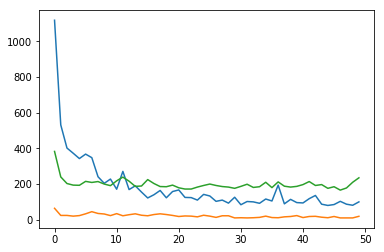

1


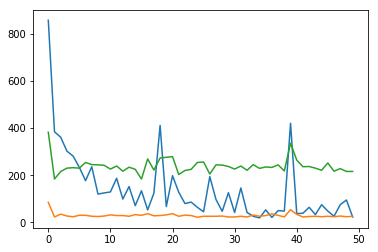

2


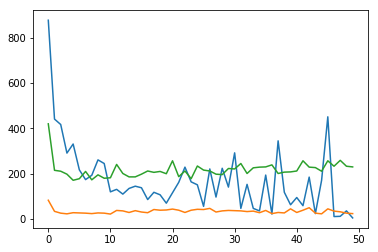

3


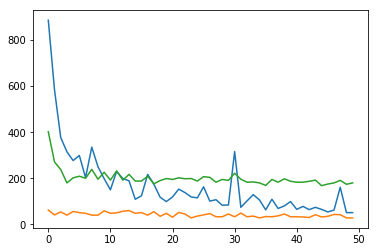

4


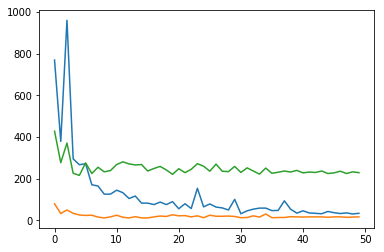

5


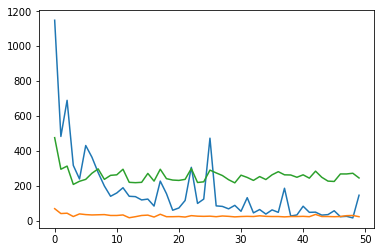

6


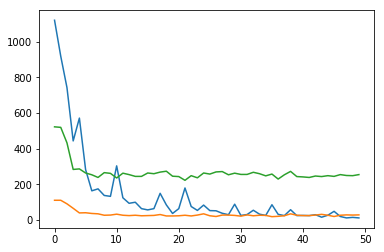

7


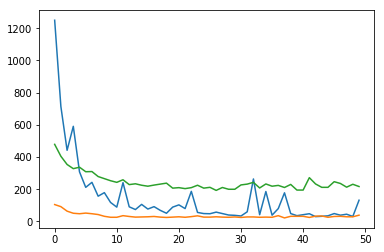

8


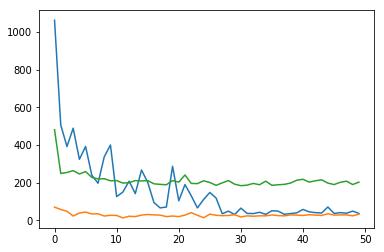

9


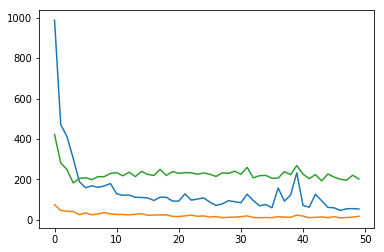

10


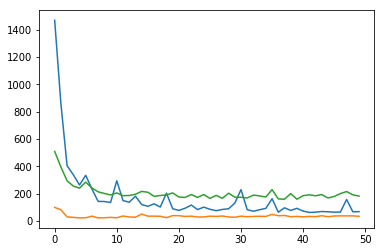

11


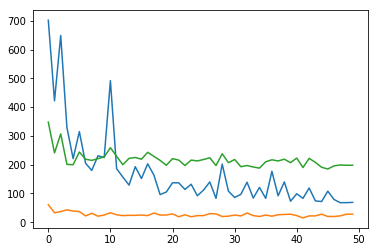

12


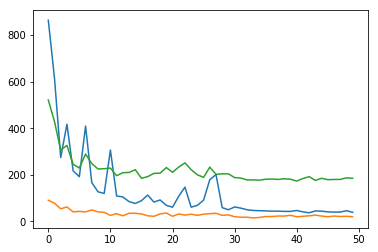

13


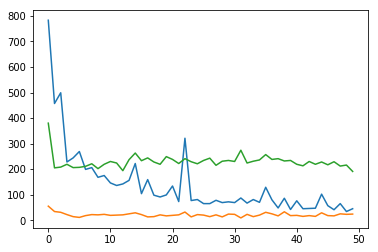

14


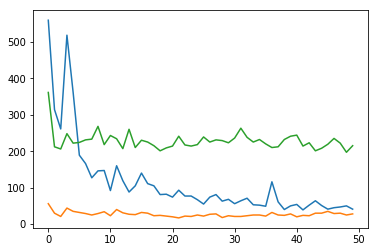

15


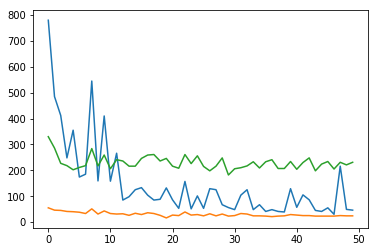

16


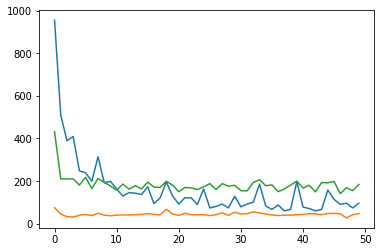

17


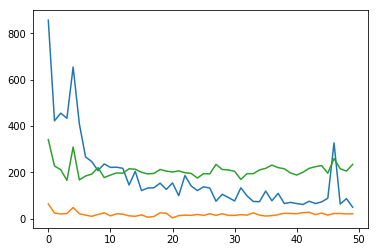

18


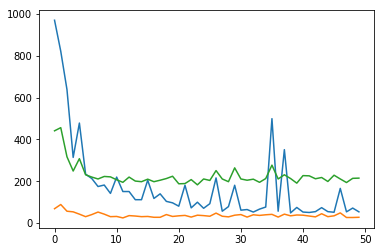

19


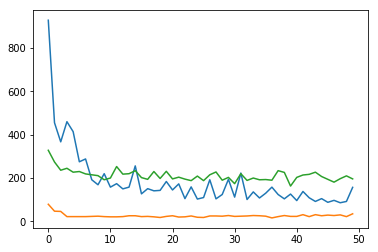

20


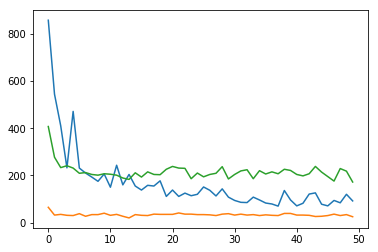

21


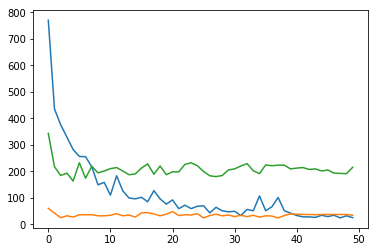

22


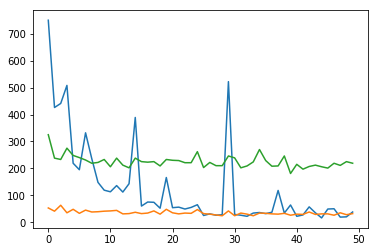

23


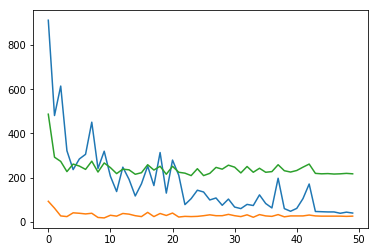

24


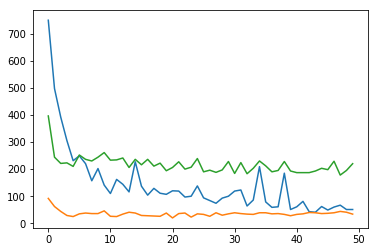

25


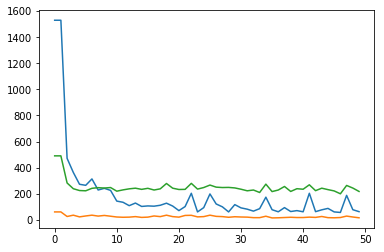

26


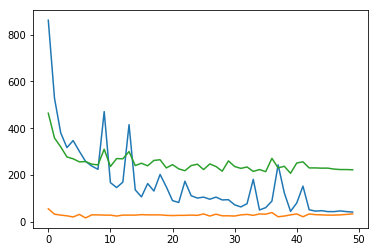

27


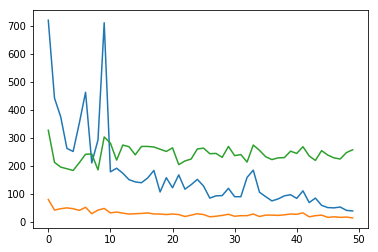

28


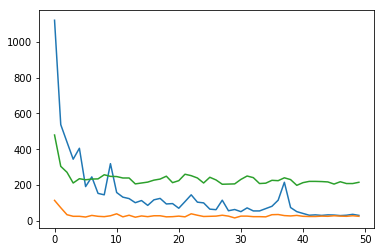

29


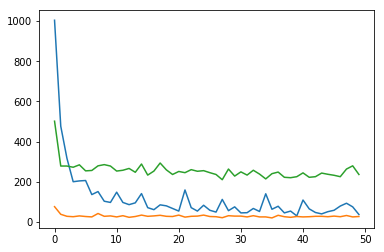

30


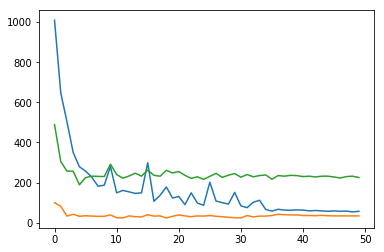

31


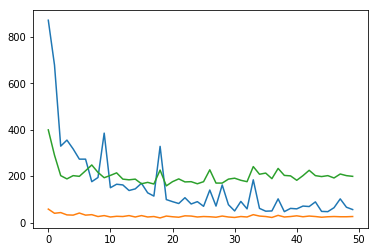

32


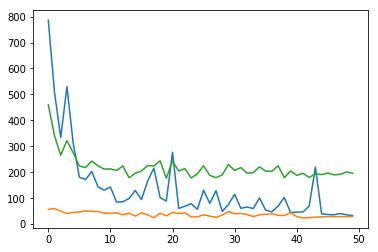

33


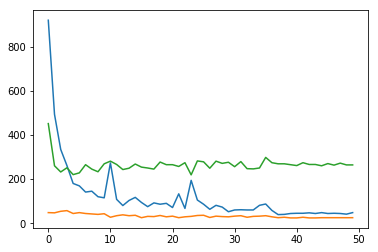

34


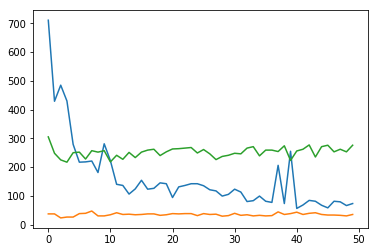

35


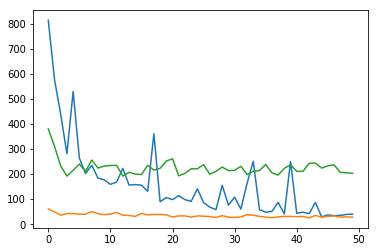

36


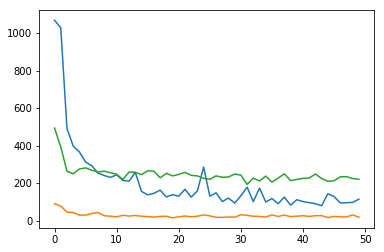

37


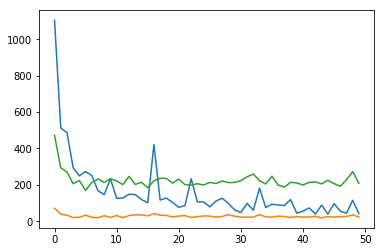

38


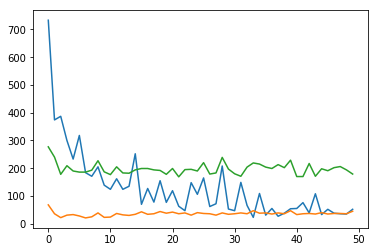

39


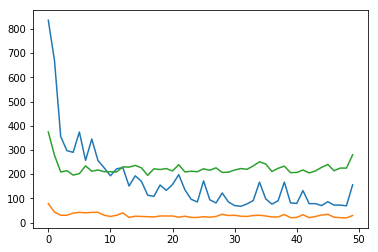

40


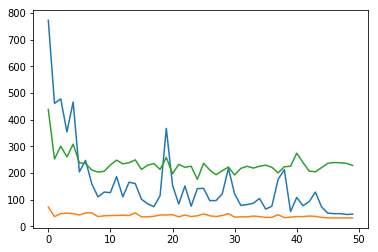

41


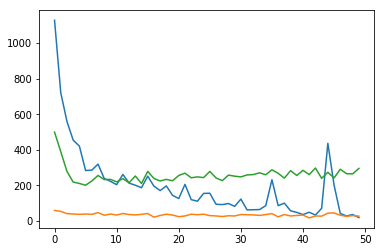

42


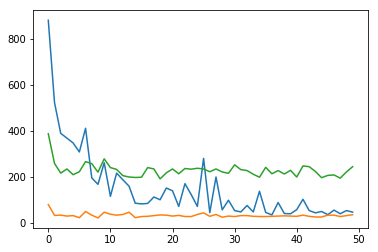

43


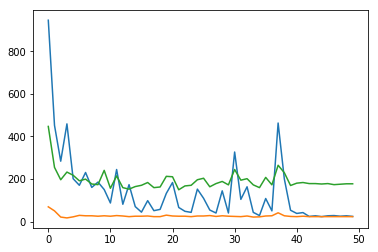

44


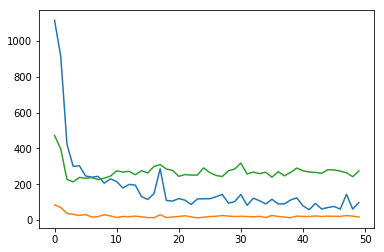

45


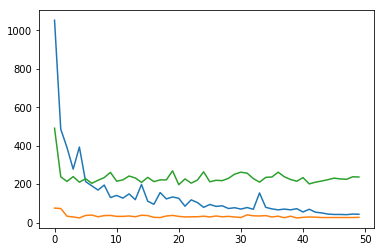

46


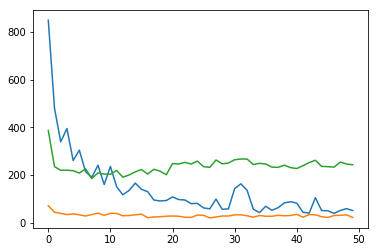

47


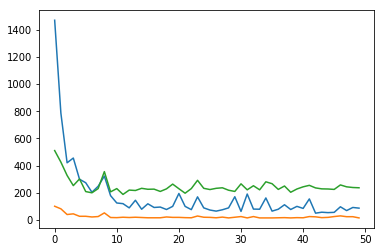

48


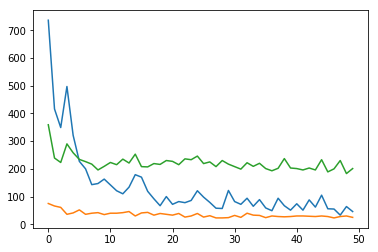

49


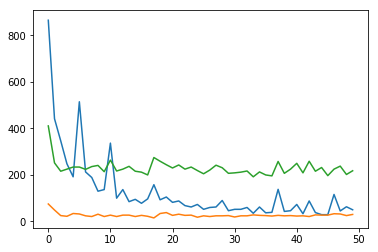

In [6]:
print(train_errors.shape)

for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(np.array(train_errors[i_rep, :]))
    plt.plot(np.array(validation_errors[i_rep, :]))
    plt.plot(np.array(test_errors[i_rep, :]))
    plt.show()

0


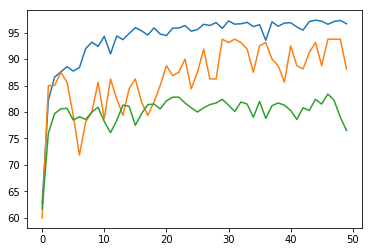

Training accuracy 96.7
Validation accuracy 88.1
Testing accuracy 76.5
1


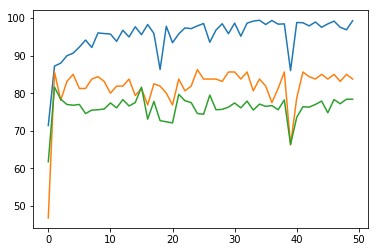

Training accuracy 99.2
Validation accuracy 83.8
Testing accuracy 78.4
2


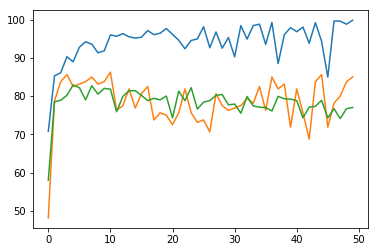

Training accuracy 99.8
Validation accuracy   85
Testing accuracy   77
3


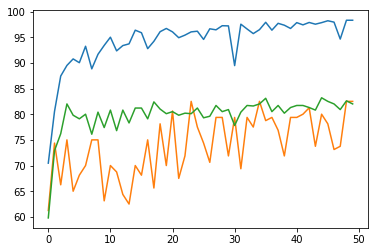

Training accuracy 98.3
Validation accuracy 82.5
Testing accuracy   82
4


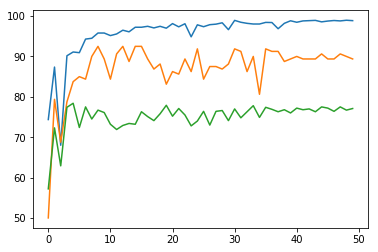

Training accuracy 98.9
Validation accuracy 89.4
Testing accuracy 77.1
5


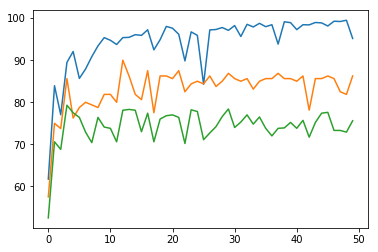

Training accuracy 95.2
Validation accuracy 86.2
Testing accuracy 75.6
6


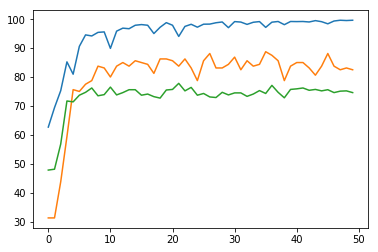

Training accuracy 99.6
Validation accuracy 82.5
Testing accuracy 74.6
7


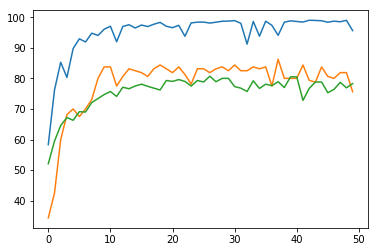

Training accuracy 95.6
Validation accuracy 75.6
Testing accuracy 78.3
8


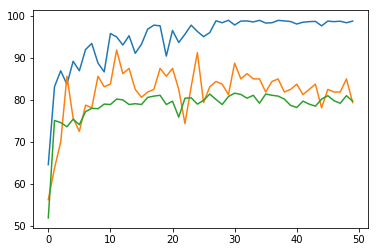

Training accuracy 98.8
Validation accuracy 79.4
Testing accuracy 79.7
9


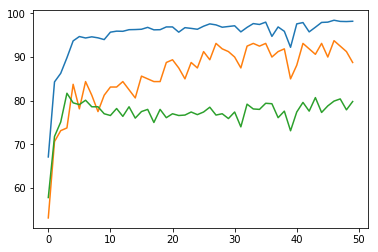

Training accuracy 98.2
Validation accuracy 88.8
Testing accuracy 79.8
10


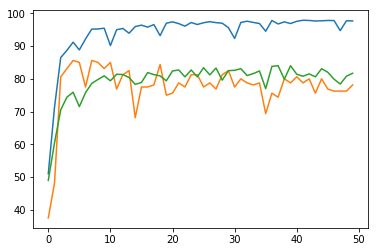

Training accuracy 97.7
Validation accuracy 78.1
Testing accuracy 81.7
11


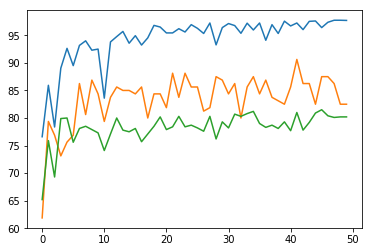

Training accuracy 97.7
Validation accuracy 82.5
Testing accuracy 80.2
12


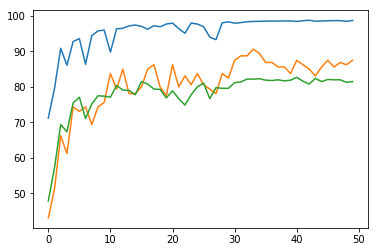

Training accuracy 98.7
Validation accuracy 87.5
Testing accuracy 81.5
13


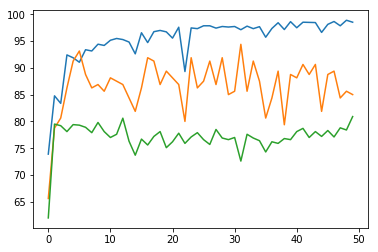

Training accuracy 98.5
Validation accuracy   85
Testing accuracy 80.9
14


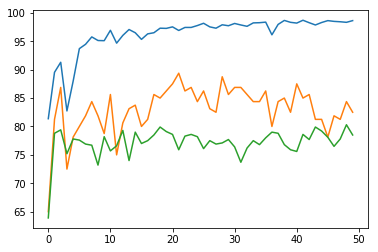

Training accuracy 98.6
Validation accuracy 82.5
Testing accuracy 78.5
15


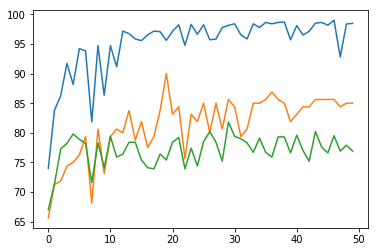

Training accuracy 98.5
Validation accuracy   85
Testing accuracy 76.9
16


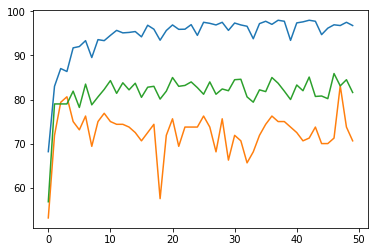

Training accuracy 96.8
Validation accuracy 70.6
Testing accuracy 81.6
17


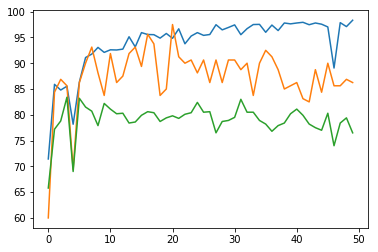

Training accuracy 98.3
Validation accuracy 86.2
Testing accuracy 76.5
18


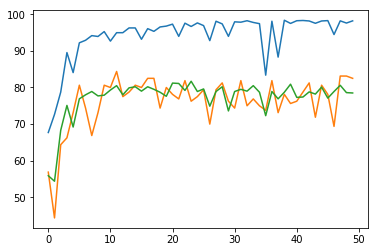

Training accuracy 98.2
Validation accuracy 82.5
Testing accuracy 78.5
19


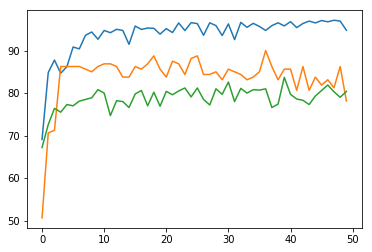

Training accuracy 94.8
Validation accuracy 78.1
Testing accuracy 80.4
20


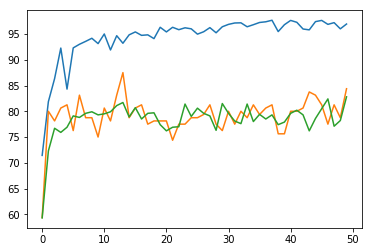

Training accuracy 96.9
Validation accuracy 84.4
Testing accuracy 82.8
21


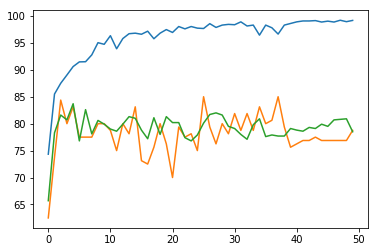

Training accuracy 99.2
Validation accuracy 78.8
Testing accuracy 78.5
22


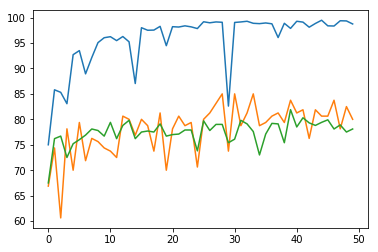

Training accuracy 98.7
Validation accuracy   80
Testing accuracy 78.1
23


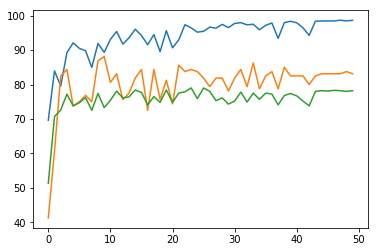

Training accuracy 98.6
Validation accuracy 83.1
Testing accuracy 78.2
24


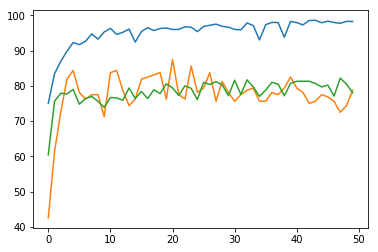

Training accuracy 98.3
Validation accuracy 78.8
Testing accuracy   78
25


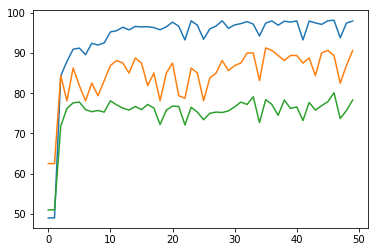

Training accuracy 97.9
Validation accuracy 90.6
Testing accuracy 78.3
26


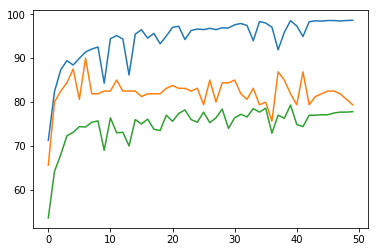

Training accuracy 98.6
Validation accuracy 79.4
Testing accuracy 77.8
27


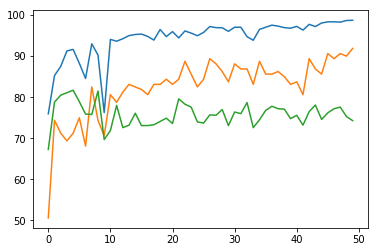

Training accuracy 98.7
Validation accuracy 91.9
Testing accuracy 74.3
28


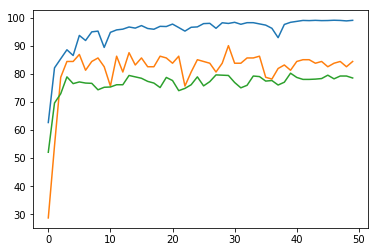

Training accuracy   99
Validation accuracy 84.4
Testing accuracy 78.5
29


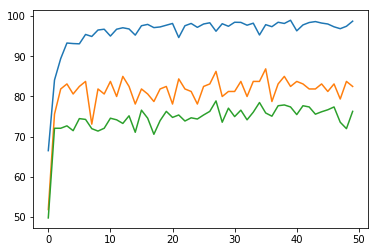

Training accuracy 98.7
Validation accuracy 82.5
Testing accuracy 76.3
30


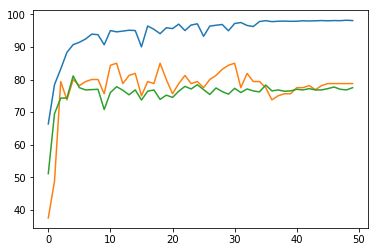

Training accuracy 98.1
Validation accuracy 78.8
Testing accuracy 77.5
31


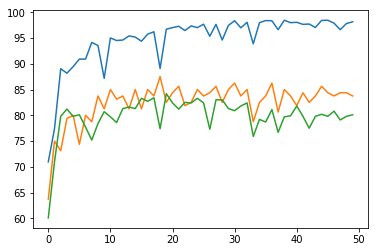

Training accuracy 98.1
Validation accuracy 83.8
Testing accuracy 80.1
32


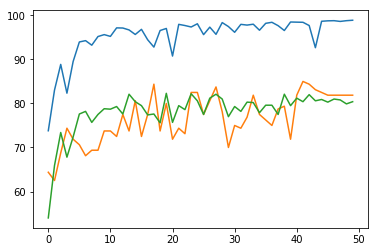

Training accuracy 98.9
Validation accuracy 81.9
Testing accuracy 80.4
33


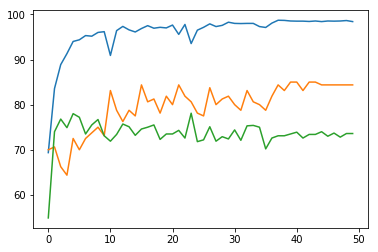

Training accuracy 98.4
Validation accuracy 84.4
Testing accuracy 73.6
34


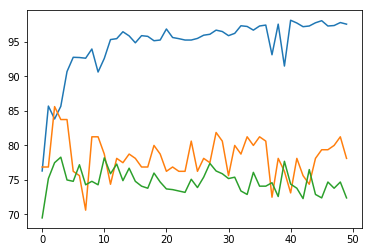

Training accuracy 97.6
Validation accuracy 78.1
Testing accuracy 72.4
35


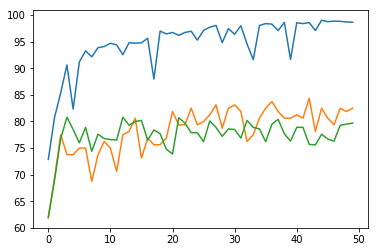

Training accuracy 98.7
Validation accuracy 82.5
Testing accuracy 79.7
36


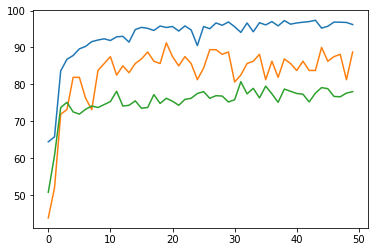

Training accuracy 96.2
Validation accuracy 88.8
Testing accuracy   78
37


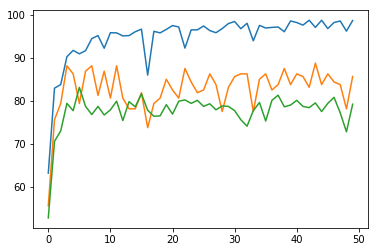

Training accuracy 98.6
Validation accuracy 85.6
Testing accuracy 79.2
38


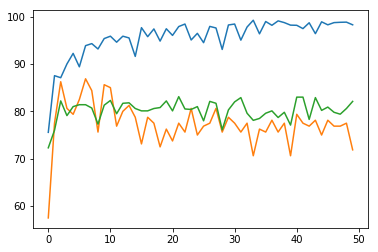

Training accuracy 98.3
Validation accuracy 71.9
Testing accuracy 82.1
39


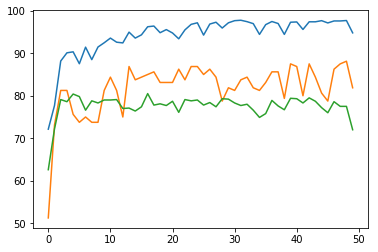

Training accuracy 94.8
Validation accuracy 81.9
Testing accuracy   72
40


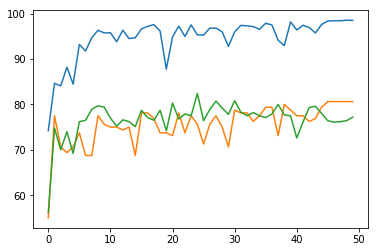

Training accuracy 98.5
Validation accuracy 80.6
Testing accuracy 77.2
41


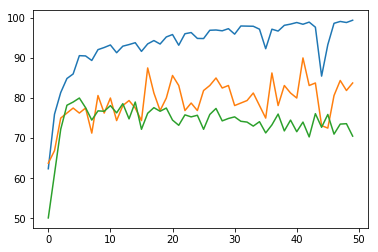

Training accuracy 99.4
Validation accuracy 83.8
Testing accuracy 70.5
42


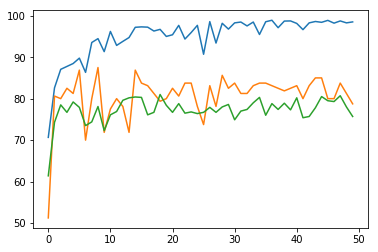

Training accuracy 98.5
Validation accuracy 78.8
Testing accuracy 75.7
43


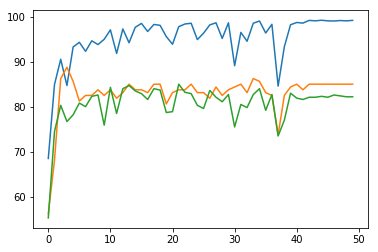

Training accuracy 99.2
Validation accuracy   85
Testing accuracy 82.2
44


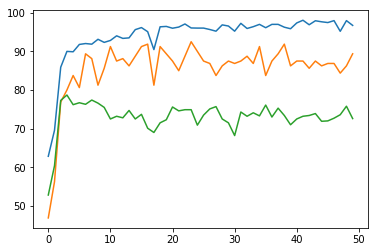

Training accuracy 96.7
Validation accuracy 89.4
Testing accuracy 72.6
45


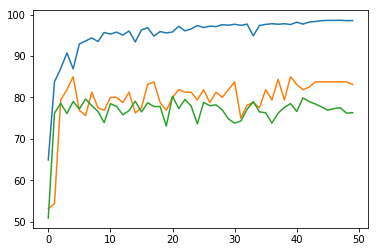

Training accuracy 98.6
Validation accuracy 83.1
Testing accuracy 76.3
46


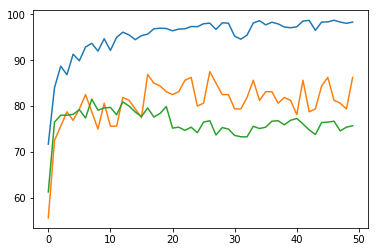

Training accuracy 98.3
Validation accuracy 86.2
Testing accuracy 75.7
47


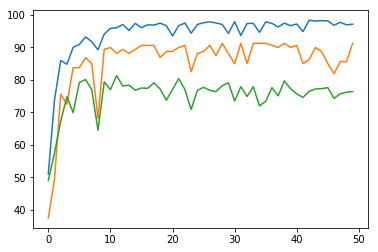

Training accuracy 97.1
Validation accuracy 91.2
Testing accuracy 76.4
48


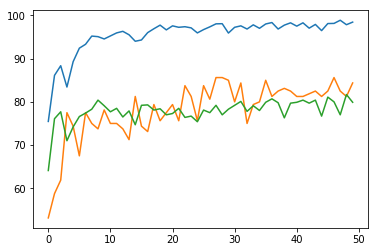

Training accuracy 98.5
Validation accuracy 84.4
Testing accuracy 79.9
49


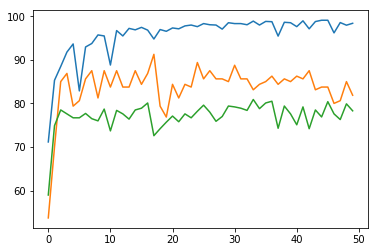

Training accuracy 98.4
Validation accuracy 81.9
Testing accuracy 78.3


In [7]:
for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(100*(Ntrain-np.array(train_errors[i_rep, :]))/Ntrain)
    plt.plot(100*(Nvalidation-np.array(validation_errors[i_rep, :]))/Nvalidation)
    plt.plot(100*(Ntest-np.array(test_errors[i_rep, :]))/Ntest)

    plt.show()
    
    print("Training accuracy {:4.3g}".format(100*(Ntrain-np.array(train_errors[i_rep, -1]))/Ntrain))
    print("Validation accuracy {:4.3g}".format(100*(Nvalidation-np.array(validation_errors[i_rep, -1]))/Nvalidation))
    print("Testing accuracy {:4.3g}".format(100*(Ntest-np.array(test_errors[i_rep, -1]))/Ntest))

(50,)
Training accuracy 98.1%+-1.1526587009429932
Validation accuracy 83.1%+-4.435227870941162
Testing accuracy 77.9%+-2.783365249633789


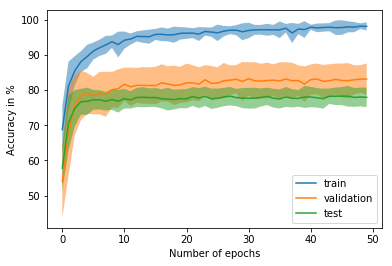

In [8]:
train_accuracy = 100*(Ntrain-np.array(train_errors))/Ntrain
val_accuracy = 100*(Nvalidation-np.array(validation_errors))/Nvalidation
test_accuracy = 100*(Ntest-np.array(test_errors))/Ntest

stddev_train_errors = np.std(train_accuracy, axis=0)
stddev_val_errors = np.std(val_accuracy, axis=0)
stddev_test_errors = np.std(test_accuracy, axis=0)

mean_train_errors = np.mean(train_accuracy, axis=0)
mean_val_errors = np.mean(val_accuracy, axis=0)
mean_test_errors = np.mean(test_accuracy, axis=0)

epoch = list(range(50))
print(stddev_train_errors.shape)

#plt.errorbar(epoch, mean_train_errors, stddev_train_errors)
#plt.errorbar(epoch, mean_val_errors, stddev_val_errors)
#plt.errorbar(epoch, mean_test_errors, stddev_test_errors)

plt.plot(epoch, mean_train_errors)
plt.plot(epoch, mean_val_errors)
plt.plot(epoch, mean_test_errors)
plt.fill_between(epoch, mean_train_errors+stddev_train_errors, mean_train_errors-stddev_train_errors, alpha=0.5)
plt.fill_between(epoch, mean_val_errors+stddev_val_errors, mean_val_errors-stddev_val_errors, alpha=0.5)
plt.fill_between(epoch, mean_test_errors+stddev_test_errors, mean_test_errors-stddev_test_errors, alpha=0.5)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation', 'test'])

print("Training accuracy {:4.3g}%+-{}".format(mean_train_errors[-1], stddev_train_errors[-1]))
print("Validation accuracy {:4.3g}%+-{}".format(mean_val_errors[-1], stddev_val_errors[-1]))
print("Testing accuracy {:4.3g}%+-{}".format(mean_test_errors[-1], stddev_test_errors[-1]))